In [1]:
import pandas as pd
import gzip
import json
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)

# Reading the 100000 rows

In [2]:
def getDF(path):
    i = 0
    df = {}
    limit = 100000
    for d in parse(path):
        df[i] = d
        i += 1
        if i == limit:
            break
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
df = getDF('Home_and_Kitchen.json.gz')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         100000 non-null  float64
 1   vote            17872 non-null   object 
 2   verified        100000 non-null  bool   
 3   reviewTime      100000 non-null  object 
 4   reviewerID      100000 non-null  object 
 5   asin            100000 non-null  object 
 6   reviewerName    99994 non-null   object 
 7   reviewText      99978 non-null   object 
 8   summary         99987 non-null   object 
 9   unixReviewTime  100000 non-null  int64  
 10  style           74156 non-null   object 
 11  image           809 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 9.3+ MB


In [5]:
print(df['reviewText'])

0        I don't use these for their original use, and ...
1        Seems a bit expensive for a plastic bottle, bu...
2                                 Great product, love it!!
3        This is a sturdy floating corner shelf!  We mo...
4        I purchased 4 of these shelves. they look grea...
                               ...                        
99995    I loved this dish, and have been using it for ...
99996    Very useful and very beautiful.  Perfect for s...
99997    works well easy clean up, lid does not set in ...
99998    This is a great product... I own a expensive J...
99999    Really does a super job of juicing!\nCan't bea...
Name: reviewText, Length: 100000, dtype: object


In [6]:
df.dropna(subset = ["reviewText"], inplace=True)

In [7]:
corpus = df['reviewText'].values

## Tokenizing and Lemmatizing using nltk

In [8]:
import nltk
from nltk.corpus import wordnet

In [9]:
# The WordNet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Acceptable parts of speech
pos_map = {'N': wordnet.NOUN, 'J': wordnet.ADJ, 'V': wordnet.VERB, 'R': wordnet.ADV }

# Function to reduce corpus to word lemmas, limited to nouns, verbs, etc. 
def clean_corpus(corpus):
    cleaned = []
    for text in corpus:
        words = []
        for sent in nltk.sent_tokenize(text):
            for (word, pos) in nltk.pos_tag(nltk.word_tokenize(sent)):
                if not pos[0] in pos_map:
                    continue
                word = lemmatizer.lemmatize(word.lower(), pos_map[pos[0]])
                words.append(word.lower())
        cleaned.append(words)
    return cleaned

# This process will take some time to complete
clean_texts = clean_corpus(corpus)

## Calculating stop words

In [10]:
from collections import Counter

# Print the 30 most frequent words, and add to stopword list
counter = Counter([w for t in clean_texts for w in t])
wordcounts = counter.most_common(n=30)
stop_words = []
for word, count in wordcounts:
    stop_words.append(word)
    print('%s%i' % (word.ljust(15), count))

be             181380
have           76576
use            48486
do             46155
not            34043
n't            32866
make           30401
great          28618
work           25027
very           24819
good           24270
get            23404
's             21492
so             21026
well           20181
buy            19578
just           19520
love           18928
time           18300
easy           18111
product        15623
up             15141
year           14564
more           12382
out            11998
clean          11693
only           11271
much           10293
little         10187
go             10127


## Getting the predefined stop words from nltk

In [ ]:
from nltk.corpus import stopwords
stop_words2 = stopwords.words('english')
stop_words.extend(stop_words2)

## Remove stopwords from each lemmatized text block

In [12]:

for i in range(len(clean_texts)):
    j = 0
    while j < len(clean_texts[i]):
        if clean_texts[i][j] in stop_words:
            del clean_texts[i][j]
        else:
            j += 1

In [13]:
len(clean_texts)

99978

In [14]:
print(clean_texts[0])

['original', 'purchase', 'need', 'replacement', 'last', 'never', 'even', 'think', 'internet', 'find', 'new', 'one', 'pleasant', 'surprise', 'find', 'immediately', 'actually', 'pay', 'le']


## Creating corpus from a list of clean texts

In [15]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(clean_texts)
corpus_new = [dictionary.doc2bow(text) for text in clean_texts]

## Pretraining lda model using the corpus and number of topics

In [16]:
from gensim.models.ldamulticore import LdaMulticore

num_topics = 20
lda = LdaMulticore(corpus_new, id2word=dictionary, num_topics=num_topics, passes=2)

## The list of topics for model 1

In [17]:
result = lda[corpus_new[0]]
print(result)
for i in range(num_topics):
    print('Topic %i: %s\n' % (i, lda.print_topic(i)))

[(7, 0.95248795)]
Topic 0: 0.016*"popcorn" + 0.012*"recommend" + 0.008*"bowl" + 0.008*"look" + 0.008*"kitchen" + 0.007*"nice" + 0.007*"item" + 0.007*"thing" + 0.007*"perfect" + 0.006*"really"

Topic 1: 0.020*"coffee" + 0.017*"cup" + 0.014*"blender" + 0.013*"tea" + 0.008*"espresso" + 0.007*"need" + 0.007*"thing" + 0.006*"'ve" + 0.006*"really" + 0.005*"hot"

Topic 2: 0.038*"coffee" + 0.009*"gift" + 0.008*"maker" + 0.008*"machine" + 0.006*"perfect" + 0.006*"taste" + 0.005*"think" + 0.005*"like" + 0.005*"purchase" + 0.005*"first"

Topic 3: 0.011*"vacuum" + 0.009*"'m" + 0.008*"pressure" + 0.008*"need" + 0.008*"small" + 0.007*"battery" + 0.007*"still" + 0.007*"handle" + 0.007*"size" + 0.007*"last"

Topic 4: 0.011*"vacuum" + 0.011*"purchase" + 0.008*"like" + 0.007*"floor" + 0.007*"battery" + 0.006*"come" + 0.006*"song" + 0.006*"really" + 0.006*"handle" + 0.006*"carpet"

Topic 5: 0.027*"knife" + 0.008*"water" + 0.007*"really" + 0.007*"lid" + 0.007*"keep" + 0.007*"hand" + 0.006*"plastic" + 0.00

## Coherence score

In [18]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=clean_texts, dictionary=dictionary, coherence='c_v')
print(coherence_model_lda.get_coherence())

0.448035267479313


In [19]:
i = 0
for topic in lda.show_topics(20):
    print(topic)
    i += 1

(0, '0.016*"popcorn" + 0.012*"recommend" + 0.008*"bowl" + 0.008*"look" + 0.008*"kitchen" + 0.007*"nice" + 0.007*"item" + 0.007*"thing" + 0.007*"perfect" + 0.006*"really"')
(1, '0.020*"coffee" + 0.017*"cup" + 0.014*"blender" + 0.013*"tea" + 0.008*"espresso" + 0.007*"need" + 0.007*"thing" + 0.006*"\'ve" + 0.006*"really" + 0.005*"hot"')
(2, '0.038*"coffee" + 0.009*"gift" + 0.008*"maker" + 0.008*"machine" + 0.006*"perfect" + 0.006*"taste" + 0.005*"think" + 0.005*"like" + 0.005*"purchase" + 0.005*"first"')
(3, '0.011*"vacuum" + 0.009*"\'m" + 0.008*"pressure" + 0.008*"need" + 0.008*"small" + 0.007*"battery" + 0.007*"still" + 0.007*"handle" + 0.007*"size" + 0.007*"last"')
(4, '0.011*"vacuum" + 0.011*"purchase" + 0.008*"like" + 0.007*"floor" + 0.007*"battery" + 0.006*"come" + 0.006*"song" + 0.006*"really" + 0.006*"handle" + 0.006*"carpet"')
(5, '0.027*"knife" + 0.008*"water" + 0.007*"really" + 0.007*"lid" + 0.007*"keep" + 0.007*"hand" + 0.006*"plastic" + 0.006*"hold" + 0.006*"small" + 0.005*"f

## Visualization of topics

In [59]:
import pyLDAvis
import pyLDAvis.gensim_models
import importlib
import warnings
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus_new, dictionary)
vis

/Users/a.n.t/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/a.n.t/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/a.n.t/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/a.n.t/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/a.n.t/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19    -0.069359  0.016060       1        1  12.107064
9     -0.069399 -0.007497       2        1  11.940828
5     -0.059602 -0.020614       3        1   9.154881
7     -0.032568 -0.051640       4        1   8.385517
1     -0.020078 -0.077704       5        1   7.802122
14     0.008261 -0.006316       6        1   5.306042
16     0.061639  0.003935       7        1   4.519161
18    -0.086162  0.086447       8        1   4.393616
2      0.010683 -0.084074       9        1   4.347615
0     -0.015237  0.063026      10        1   3.782224
8      0.110376  0.037657      11        1   3.684881
3     -0.012575 -0.003903      12        1   3.577297
10     0.012694 -0.004133      13        1   3.555681
15    -0.004737  0.027150      14        1   3.139110
6      0.027778  0.012076      15        1   3.103248
17    -0.008732  0.014656      16        1   2.983122
11     0.010550 -0.030232      17        1   2.252505
4      0.066153  0.014876      18        1   2.219581
13     0.013952  0.005519      19        1   2.110737
12     0.056363  0.004711      20        1   1.634770, topic_info=         Term         Freq        Total Category  logprob  loglift
198    coffee  8855.000000  8855.000000  Default  30.0000  30.0000
12447  vacuum  9365.000000  9365.000000  Default  29.0000  29.0000
9572    knife  7758.000000  7758.000000  Default  28.0000  28.0000
2906      pan  7102.000000  7102.000000  Default  27.0000  27.0000
173       tea  3179.000000  3179.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
44       look   136.465095  9601.345313  Topic20  -5.5138  -0.1399
362     still   120.929231  6818.164953  Topic20  -5.6347   0.0815
172      take   115.409188  7717.284821  Topic20  -5.6814  -0.0891
150      long   109.470117  6076.935707  Topic20  -5.7343   0.0971
146      keep   107.259874  7032.118223  Topic20  -5.7546  -0.0693

[1698 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
29         1  0.118033        'm
29         2  0.096137        'm
29         3  0.101358        'm
29         4  0.077577        'm
29         5  0.074822        'm
...      ...       ...       ...
12354     19  0.044897     yeast
12354     20  0.008979     yeast
13187     12  0.895794     yerba
3478      12  0.847375    zombie
26049     17  0.928815  zwilling

[9503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 10, 6, 8, 2, 15, 17, 19, 3, 1, 9, 4, 11, 16, 7, 18, 12, 5, 14, 13])

## Creating the model for number of topics from 5 to 20

In [25]:
import gensim
def compute_coherence_values(dictionary, corpus_new, clean_texts, limit, start=5, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model_v2 = LdaMulticore(corpus_new, id2word=dictionary, num_topics=num_topics, passes=2)
        model_list.append(model_v2)
        coherencemodel = CoherenceModel(model=model_v2, texts=clean_texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus_new=corpus_new, clean_texts=clean_texts, start=5, limit=20, step=1)

## Visualization to choose the best model

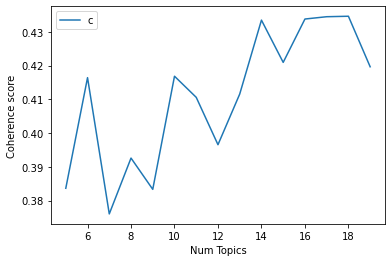

In [26]:
limit=20; start=5; step=1;
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [73]:
lda_v2 = LdaMulticore(corpus_new, id2word=dictionary, num_topics=14, passes=2)
coherence_model_lda_v2 = CoherenceModel(model=lda_v3, texts=clean_texts, dictionary=dictionary, coherence='c_v')
print(coherence_model_lda.get_coherence())

0.448035267479313


## For the maximum coherence score

In [76]:
import pyLDAvis
import pyLDAvis.gensim_models
import importlib
import warnings
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_v2, corpus_new, dictionary)
vis

/Users/a.n.t/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/a.n.t/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.035724 -0.004195       1        1  17.681752
1      0.023757  0.053344       2        1  12.402818
9      0.056656  0.030528       3        1   8.246788
13     0.013772  0.031225       4        1   8.235189
6      0.029906 -0.052072       5        1   7.557753
11     0.017198 -0.014606       6        1   6.247579
7      0.038384  0.009778       7        1   6.159743
4      0.021260 -0.028932       8        1   5.994961
2     -0.030780  0.045156       9        1   5.827081
10     0.002931 -0.053598      10        1   5.751641
8     -0.023066 -0.052578      11        1   5.417557
0     -0.099050 -0.013706      12        1   4.244919
12    -0.036174  0.017870      13        1   3.573337
5     -0.050517  0.031786      14        1   2.658882, topic_info=           Term         Freq        Total Category  logprob  loglift
198      coffee  9124.000000  9124.000000  Default  30.0000  30.0000
12447    vacuum  9936.000000  9936.000000  Default  29.0000  29.0000
4248   pressure  9991.000000  9991.000000  Default  28.0000  28.0000
10240    cooker  9987.000000  9987.000000  Default  27.0000  27.0000
10994   blender  4518.000000  4518.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
84         like   200.830115  7093.411726  Topic14  -5.6138   0.0628
2          find   192.560956  7650.081678  Topic14  -5.6559  -0.0548
1          even   187.868136  7350.845813  Topic14  -5.6806  -0.0396
191         've   196.512626  9280.753360  Topic14  -5.6356  -0.2277
29           'm   184.386867  7105.783921  Topic14  -5.6993  -0.0244

[1227 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
29         1  0.186749        'm
29         2  0.196037        'm
29         3  0.047848        'm
29         4  0.088097        'm
29         5  0.066847        'm
...      ...       ...       ...
22756     11  0.039615    zester
22756     12  0.066025    zester
22756     13  0.009904    zester
22756     14  0.006603    zester
26049      4  0.984612  zwilling

[6016 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 10, 14, 7, 12, 8, 5, 3, 11, 9, 1, 13, 6])

In [66]:
i = 0
for topic in lda_v2.show_topics(20):
    print(topic)
    i += 1

(0, '0.010*"handle" + 0.009*"bowl" + 0.008*"\'m" + 0.008*"look" + 0.007*"small" + 0.007*"nice" + 0.007*"item" + 0.006*"hold" + 0.006*"need" + 0.006*"sturdy"')
(1, '0.008*"*" + 0.008*"small" + 0.007*"cake" + 0.006*"song" + 0.006*"vacuum" + 0.005*"eminem" + 0.005*"say" + 0.005*"enough" + 0.005*"also" + 0.005*"peel"')
(2, '0.012*"blender" + 0.009*"quality" + 0.007*"first" + 0.007*"handle" + 0.007*"come" + 0.006*"pressure" + 0.006*"\'ve" + 0.006*"water" + 0.006*"plastic" + 0.005*"last"')
(3, '0.013*"coffee" + 0.006*"say" + 0.005*"first" + 0.005*"size" + 0.005*"take" + 0.005*"still" + 0.005*"opener" + 0.005*"last" + 0.005*"purchase" + 0.005*"vacuum"')
(4, '0.023*"vacuum" + 0.013*"really" + 0.009*"floor" + 0.008*"bag" + 0.006*"price" + 0.006*"song" + 0.005*"look" + 0.005*"need" + 0.005*"also" + 0.005*"suction"')
(5, '0.013*"pan" + 0.011*"pressure" + 0.010*"cooker" + 0.010*"coffee" + 0.009*"pot" + 0.009*"cook" + 0.007*"come" + 0.006*"\'ve" + 0.005*"also" + 0.005*"need"')
(6, '0.009*"fan" + 0.

## Getting the probability for each review to belong to a topic

In [95]:
get_document_topics_list = [lda_v2.get_document_topics(text) for text in corpus_new]

In [93]:
get_document_topics_list[10]

[(0, 0.9926149)]

In [83]:
get_document_topics_list[1001]

[(1, 0.93992877)]

In [91]:
get_document_topics_list[10101]

[(0, 0.014292308),
 (1, 0.014291786),
 (2, 0.014291698),
 (3, 0.0142916525),
 (4, 0.014292527),
 (5, 0.871316),
 (6, 0.014291554),
 (7, 0.014348428),
 (8, 0.014292188),
 (9, 0.014291858)]

In [94]:
print(df['reviewText'][10])

This mug comes in a variety of colors most of which are hard to find on Amazon, easy to find on the seller's website but not easy to order. It's worth the effort of figuring out how to place the order though, as this mug keeps tea hot for a good couple of hours, and even longer if left in a sunny car. I have tried a variety of different travel mugs of similar size and this one is by far the best for not retaining the flavor of the previous cup of tea thanks to its metal instead of plastic interior. Additionally it is better designed, fitting nicely in the car cup-holder and having a flat lid that doesn't poke your nose every time you take a sip, and allows you to close the hole in the lid by sliding the cover with your teeth so you don't have to take both hands off the wheel while driving. The only minor quibble is that the sliding cover is a little hard to clean underneath (by hand, we don't use a dish-washer for anything) - this is not a problem for black or fruit teas, but if you ta

In [84]:
print(df['reviewText'][1001])

Not only do I have fun with it, I took it to school and put the words on the side of my desk and my students have a blast making up encouraging sentences.  My only regret is that the words aren't a little bigger.


In [92]:
print(df['reviewText'][10101])

good, all-around cooker!


In [67]:
clean_texts_v2 = clean_texts.copy()

In [49]:
from nltk.corpus import words
type(words)

nltk.corpus.util.LazyCorpusLoader

## Trying to remove non english words

In [50]:

for i in range(len(clean_texts_v2)):
    j = 0
    while j < len(clean_texts_v2[i]):
        if clean_texts_v2[i][j] not in words.words():
            del clean_texts_v2[i][j]
        else:
            j += 1

KeyboardInterrupt: 

In [57]:
for i in range(len(clean_texts_v2)):
    j = 0
    while j < len(clean_texts_v2[i]):
        if len(clean_texts_v2[i][j])<2 :
            del clean_texts_v2[i][j]
        else:
            j += 1

In [60]:
dictionary_v2 = Dictionary(clean_texts_v2)
corpus_new_v2 = [dictionary.doc2bow(text) for text in clean_texts_v2]

## Failed Model 3

In [65]:
model_v3 = LdaMulticore(corpus_new_v2, id2word=dictionary_v2, num_topics=10, passes=2)
coherencemodel_v2 = CoherenceModel(model=model_v3, texts=clean_texts_v2, dictionary=dictionary_v2, coherence='c_v')

IndexError: index 45861 is out of bounds for axis 1 with size 43455

In [97]:
import pickle
pickle.dump(lda_v2,open("topic.model","wb"))